# Image Stitching using Homography

In [19]:
#%matplotlib notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipyevents import Event
from ipywidgets import Image
from ipywidgets import Output
from ipycanvas import Canvas

In [20]:
# Function to convert image from BGR to RGB
def BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Function to show images
def show_images(image1, image2):
    fig = plt.figure(figsize=(20, 20))
    columns = 3
    rows = 1

    fig.add_subplot(4,4,(1,2))
    plt.imshow(BGR2RGB(image1))

    fig.add_subplot(4,4,(3,4))
    plt.imshow(BGR2RGB(image2))

## Selection of source images

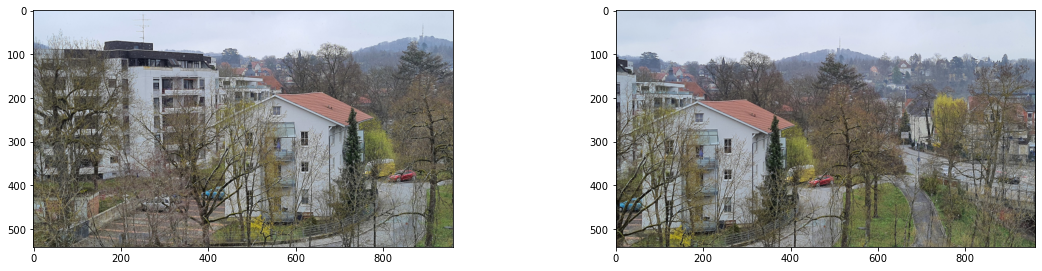

In [21]:
# Read the first image
#image1 = cv2.imread('fruit-basket_a.jpg')
image1 = cv2.imread('image1-960.jpg')

# Read the second image
#image2 = cv2.imread('fruit-basket_b.jpg')
image2 = cv2.imread('image2-960.jpg')

# Initialize maximum number of points for selection
maximum_number_of_points_to_select = 8

# Initialize indices for point selection
index1 = 0
index2 = 0

# Define colors for point selection
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
number_of_colors = len(colors)

show_images(image1, image2)

## Selection of corresponding coordinates

In [25]:
# Event to select coordinates from the first image
def click_event_image1( x, y):
    
    global image1_coordinates
    global index1
    global temp_image_1
    global canvas
    
    
    if index1 >= maximum_number_of_points_to_select:
        return
    
    # Displaying the selected coordinate
    if index1 < maximum_number_of_points_to_select:
        image1_coordinates.append([x, y, 1])   
        
        canvas.font = '32px serif'
        canvas.fill_text(str(index1+1), x, y)
            
        index1 = index1 + 1
        

        
# Event to select coordinates from the second image
def click_event_image2(x, y):
    
    global image2_coordinates
    global index2
    global temp_image_2
    global canvas
    global img_width

    
    if index2 >= maximum_number_of_points_to_select:
        return
    
    # Displaying the selected coordinate
    if index2 < maximum_number_of_points_to_select:
        image2_coordinates.append([x, y, 1])
        canvas.font = '32px serif'
        canvas.fill_text(str(index2+1), x+img_width, y)
        
        index2 = index2 + 1
            
        

In [31]:
# Define temporary images for point selection
temp_image_1 = image1.copy()
temp_image_2 = image2.copy()

# Initialize empty lists to store selected coordinates
image1_coordinates = []
image2_coordinates = []

# set indices back to 0
global index1, index2
index1 = 0
index2 = 0



img_height = len(image1)
img_width = len(image1[0])
img2_height = len(image2)
img2_width = len(image2[0])

img1 = Image.from_file('image1-960.jpg')
img2 = Image.from_file('image2-960.jpg')

canvas = Canvas(width=img_width+img2_width, height=img_height)
canvas.draw_image(img1, 0, 0)
canvas.draw_image(img2, img_width, 0)

out = Output()



@out.capture()
def handle_mouse_down(x, y):
    #print('Mouse down event:', x, y)
    canvas.fill_style = 'white'
    canvas.fill_circle(x,y,5)
    if x < img_width:
        click_event_image1( x, y)
    else:
        click_event_image2( x-img_width, y)
        
    
    
canvas.on_mouse_down(handle_mouse_down)

display(out)
canvas


Output()

Canvas(height=541, width=1920)

## Combining images to view correspondencies

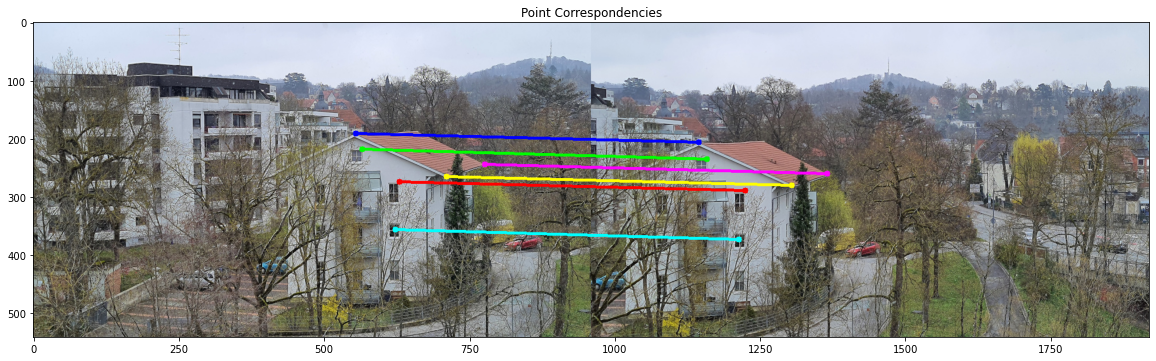

In [39]:
# Combining images to show correspondencies

fill1=0
fill2=0
if np.size(image1,0)==np.size(image2,0):
    combined=cv2.hconcat([image1,image2])
else:
    maxHeight=np.max([np.size(image1,0),np.size(image2,0)])
    minHeight=np.min([np.size(image1,0),np.size(image2,0)])
    fill1=maxHeight-np.size(image1,0)
    fill2=maxHeight-np.size(image1,0)
    image1f=[]
    image2f=[]
    if fill1!=0:
        f=np.zeros((maxHeight-minHeight,np.size(image1,1),3),np.uint8)
        image1f=cv2.vconcat([f,image1])
        image2f=image2.copy()
    else:
        f=np.zeros((maxHeight-minHeight,np.size(image2,1),3),np.uint8)
        image2f=cv2.vconcat([f,image2])
        image1f=image1.copy()
    combined=cv2.hconcat([image1f,image2f])

for i in range(0, len(image1_coordinates), 1):
    point_in_image1 = (int(image1_coordinates[i][0]), int(image1_coordinates[i][1]))
    point_in_image2_with_offset = (int(image2_coordinates[i][0]+image1.shape[1]), int(image2_coordinates[i][1]))
    
    cv2.circle(combined, point_in_image1, 5, colors[i % number_of_colors], -1)
    cv2.circle(combined, point_in_image2_with_offset, 5, colors[i % number_of_colors], -1)
    cv2.line(combined, point_in_image1, point_in_image2_with_offset, colors[i % number_of_colors],3)
    
cv2.imwrite("combined_with_correspondencies.jpg",combined)

fig = plt.figure(figsize=(20, 20))
columns = 2
rows = 2

fig.add_subplot(2,2,(1,2))               
plt.title('Point Correspondencies')
plt.imshow(BGR2RGB(combined))
plt.show()

## Apply Homography

In [33]:
#find homography

A = np.zeros((2*len(image1_coordinates),9))

for i in range(0, len(image1_coordinates)):
    A[2*i][0] = image2_coordinates[i][0]*image1_coordinates[i][2] # x*w'
    A[2*i][1] = image2_coordinates[i][1]*image1_coordinates[i][2] # y*w'
    A[2*i][2] = image2_coordinates[i][2]*image1_coordinates[i][2] # w*w'
    
    A[2*i][6] = -1*image2_coordinates[i][0]*image1_coordinates[i][0] # -x*x'
    A[2*i][7] = -1*image2_coordinates[i][1]*image1_coordinates[i][0] # -y*x'
    A[2*i][8] = -1*image2_coordinates[i][2]*image1_coordinates[i][0] # -w*x'
    
    A[2*i+1][3] = image2_coordinates[i][0]*image1_coordinates[i][2] #x*w'
    A[2*i+1][4] = image2_coordinates[i][1]*image1_coordinates[i][2] #y*w'
    A[2*i+1][5] = image2_coordinates[i][2]*image1_coordinates[i][2] #w*w'
    
    A[2*i+1][6] = -1*image2_coordinates[i][0]*image1_coordinates[i][1] #-x*y'
    A[2*i+1][7] = -1*image2_coordinates[i][1]*image1_coordinates[i][1] #-y*y'
    A[2*i+1][8] = -1*image2_coordinates[i][2]*image1_coordinates[i][1] #-w*y'
    
# Get svd
u,s,v_trans = np.linalg.svd(A)
h = v_trans[8]

# Normalize homography and put into matrix form
homography = np.array([ [ h[0]/h[8], h[1]/h[8], h[2]/h[8] ], [ h[3]/h[8], h[4]/h[8], h[5]/h[8] ], [ h[6]/h[8], h[7]/h[8], h[8]/h[8] ] ])

homography = np.around(homography, decimals=4)
print(homography)

[[ 4.810000e-01  3.420000e-02  4.019978e+02]
 [-1.266000e-01  8.651000e-01  1.716430e+01]
 [-5.000000e-04  0.000000e+00  1.000000e+00]]


## Warp images to get the results

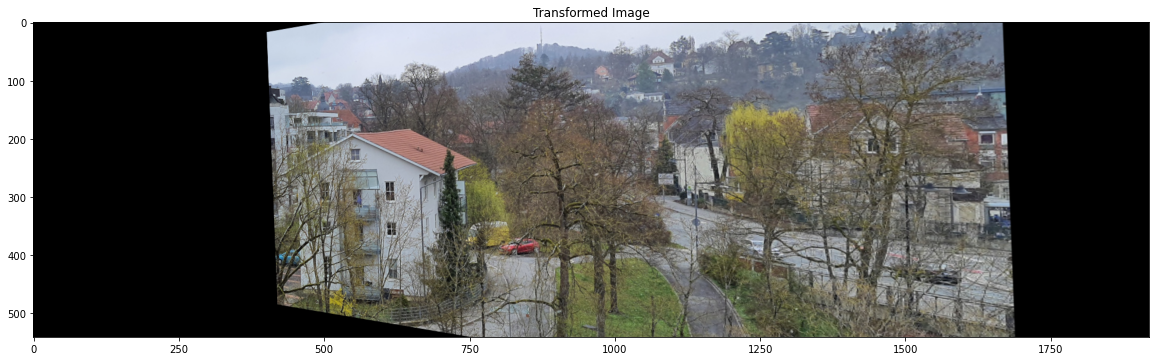

In [34]:
# Transform the second image with homography
resulting_image = cv2.warpPerspective(image2, homography, (image1.shape[1] + image2.shape[1], image1.shape[0]))

# Show the results
fig = plt.figure(figsize=(20, 20))
columns = 2
rows = 2

fig.add_subplot(2,2,(1,2))               
plt.title('Transformed Image')
plt.imshow(BGR2RGB(resulting_image))
plt.show()

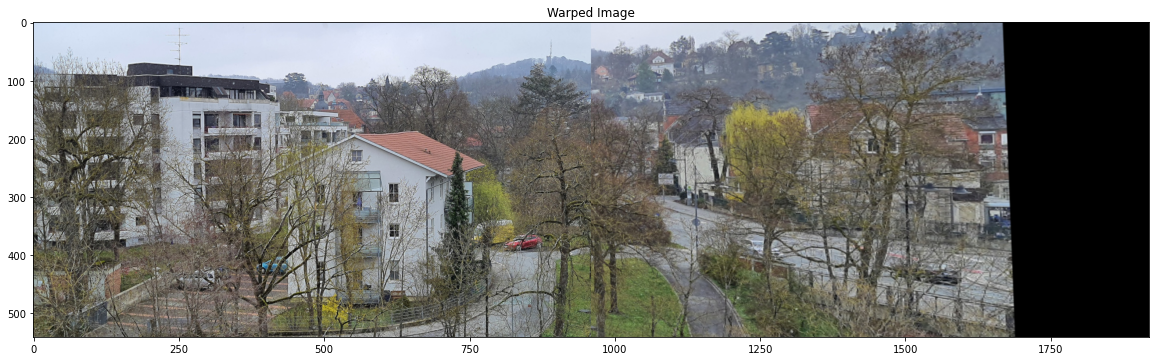

In [35]:
# Warp the transformed image with the first image by filling pixels from image1
resulting_image[0:image1.shape[0], 0:image1.shape[1]] = image1
resulting_image = BGR2RGB(resulting_image)

# Show the results
fig = plt.figure(figsize=(20, 20))
columns = 2
rows = 2

fig.add_subplot(2,2,(1,2))               
plt.title('Warped Image')
plt.imshow(resulting_image)
plt.show()